In [41]:
import h5py
import sys
sys.path.append('..')
from modules.configfile import config
import numpy as np
from modules.vizhelpercode import viewArbitraryVolume

ImportError: No module named 'mayavi'

In [2]:
hdf5_file = h5py.File(config['hdf5_filepath_prefix'], mode='r')

In [3]:
hdf5_file_g = hdf5_file['original_data']

In [120]:
masks = hdf5_file_g['training_data_segmasks_hgg']

In [121]:
masks

<HDF5 dataset "training_data_segmasks_hgg": shape (210, 240, 240, 155), type "<i2">

In [122]:
image = masks[10]

<img alt="" height="279" src="https://www.med.upenn.edu/sbia/assets/user-content/BRATS_tasks.png" width="700">

The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue). (Figure taken from the BraTS IEEE TMI paper.)

### However, in the segmentation mask, the encoding is this - 

    1 for necrosis
    2 for edema
    3 for non-enhancing tumor
    4 for enhancing tumor
    0 for everything else

In [123]:
masks = {}
bimg = np.zeros(np.shape(image))

names = {1: 'necrotic',
         2: 'edema',
         3: 'non_enhancing',
         4: 'enhancing'}

for key, val in names.items():
    tmp = np.copy(bimg)
    tmp[np.where(image == key)] = 1
    masks[val] = tmp


In [124]:
new_masks = {}
new_masks['necrotic'] = masks['necrotic']
new_masks['enhancing'] = np.logical_or(masks['enhancing'], new_masks['necrotic'])
new_masks['non_enhancing'] = np.logical_or(masks['non_enhancing'], new_masks['enhancing'])
new_masks['edema'] = np.logical_or(masks['edema'], new_masks['non_enhancing'])

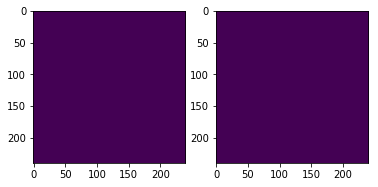

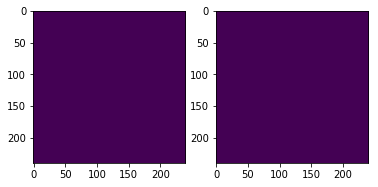

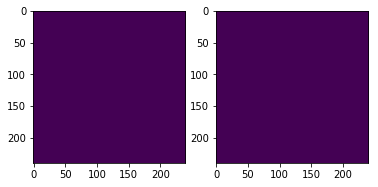

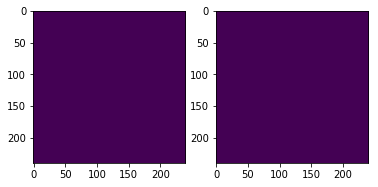

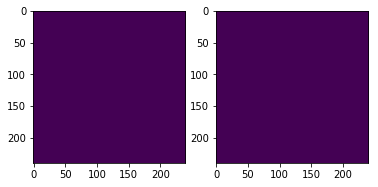

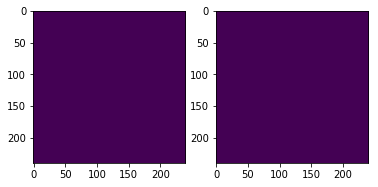

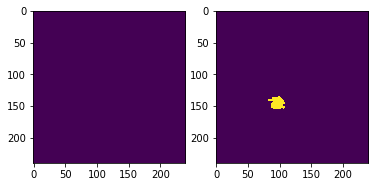

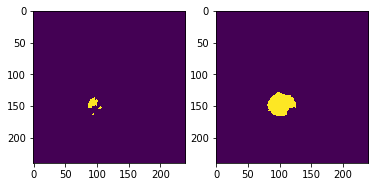

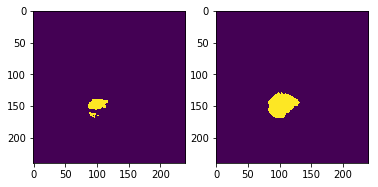

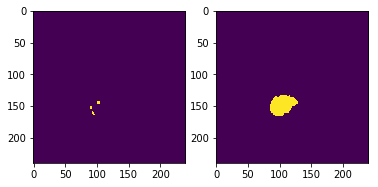

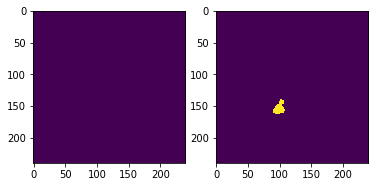

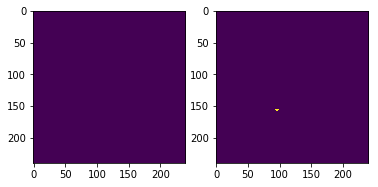

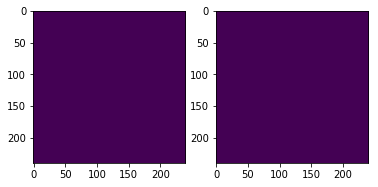

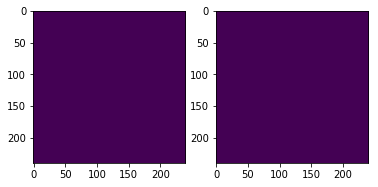

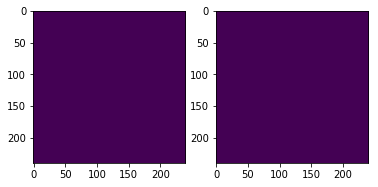

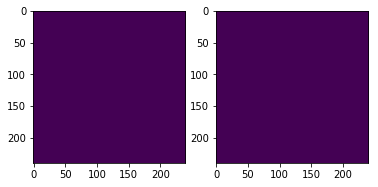

In [126]:
a = 'necrotic'
b = 'enhancing'

for i in range(0, 155, 10):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(new_masks[a][:,:,i])
    ax[1].imshow(new_masks[b][:,:,i])
    plt.show()

<img alt="" height="279" src="Hypothesis.png" width="700">

# Hypothesis

```
- Necrotic Core  (A) <INSIDE> Enhancing (B)
- Enhancing (B) <INSIDE> Non-Enhancing (C)
- Non-Enhancing (C) <INSIDE> Edema (D)
```

It might be a good idea to also check if:
```
- A <INSIDE> B
- A <INSIDE> C
- A <INSIDE> D

- B <INSIDE> C
- B <INSIDE> D

- C <INSIDE> D
```

In [116]:
codenames = {
    'A': 'necrotic',
    'B': 'enhancing',
    'C': 'non_enhancing',
    'D': 'edema'
}
epsilon = 0.0001
def checkInside(new_masks, row, col):
    print(row, col)
    getRowKey = codenames[row]
    getColKey = codenames[col]
    print(getRowKey, getColKey)
    rowMask = new_masks[getRowKey]
    colMask = new_masks[getColKey]
    
    # this can be generic, as x,y,z are just corrdinates
    X = Y = 0
    for x in range(0, np.shape(rowMask)[0]):
        for y in range(0, np.shape(rowMask)[1]):
            for z in range(0, np.shape(rowMask)[2]):
                if rowMask[x,y,z] == 0 and colMask[x,y,z] > 0: # pixel is background in row and foreground in col
                    X += 1
                else:
                    Y += 1
    
    return (float(Y) * 100.0) / (Y + X)
                
exp = {
    'A': ['B', 'C', 'D'],
    'B': ['C', 'D'], 
    'C': ['D']
      }

for row in exp:
    for col in exp[row]:
        perc = checkInside(new_masks, row, col)
        print('{} <INSIDE> {} = {}'.format(row, col, perc))
        print('')

B C
enhancing non_enhancing
B <INSIDE> C = 100.0

B D
enhancing edema
B <INSIDE> D = 99.26463933691757

C D
non_enhancing edema
C <INSIDE> D = 99.26463933691757

A B
necrotic enhancing
A <INSIDE> B = 99.61314964157707

A C
necrotic non_enhancing
A <INSIDE> C = 99.61314964157707

A D
necrotic edema
A <INSIDE> D = 98.87778897849462



In [94]:
np.nonzero(np.array([0,1,1]))[0]

array([1, 2])